In [91]:
# подключение библиотек
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.lines as lines

In [92]:
def readData(fname:str, sizeOneSignal:int):
    """Чтение данных из файла и их преобразование.
    @param fname Название входного файла.
    @param sizeOneSignal Количество элементов
     в одном сигнале."""
    data = []
    with open(fname, 'r') as inf:
        for line in inf.readlines():
            removeStrFirst = line.replace("[", "")
            removeStrSecond = removeStrFirst.replace("]", "")
            data.append(removeStrSecond.split(", "))

    floatData = []
    for oneData in data:
        floatData.append([float(x) for x in oneData])

    newData = np.asarray(floatData)
    data = np.reshape(newData,(newData.shape[1]//sizeOneSignal, sizeOneSignal))
    return data

In [93]:
def createIndArray(array):
    """Создание массива индексов для 
    данных одного сигнала.
    @param array Данные."""
    indAdday = [obj for obj in range(len(array))]
    return indAdday

In [94]:
def plotSignal(signal, ind, title):
    """Отрисовка данных одного сигнала.
    @param signal Данные одного сигнала(y).
    @param ind Индексы данных(x)."""
    plt.title(title)
    plt.plot(ind, signal)
    plt.show()

In [95]:
def findZones(signal):
    # построение гистограмм для поиска фона, сигнала, переходов
    bin = int(math.log2(len(signal)+1))
    hist = plt.hist(signal,bins=bin)
    plt.show()

    count = []
    start = []
    finish = []
    types = [0] * bin
    
    for i in range(bin):
        count.append(hist[0][i])
        start.append(hist[1][i])
        finish.append(hist[1][i+1])

    sortedHist = sorted(count)
    repeat = 0
    for i in range(bin):
        for j in range(bin):
            if sortedHist[len(sortedHist) - 1 - i] == count[j]:
                if repeat == 0:
                    types[j] = "background"
                elif repeat == 1:
                    types[j] = "signal"
                else:
                    types[j] = "transition"
                repeat += 1

    return start, finish, types

In [96]:
def convertData(signal, indArray, start, finish, types):
    pointTypes = [0]*len(indArray)
    zones = []
    typeZones = []
    
    for i in range(len(indArray)):
        for j in range(len(types)):
            if (signal[i] >= start[j]) and (signal[i] <= finish[j]):
                pointTypes[i] = types[j]
    
    currType = pointTypes[0]
    start = 0
    for i in range(len(pointTypes)):
        if currType != pointTypes[i]:
            finish = i
            typeZones.append(currType)
            zones.append([start, finish])
            start = finish
            currType = pointTypes[i]
    
    if currType != typeZones[len(typeZones) - 1]:
        typeZones.append(currType)
        zones.append([finish, len(indArray) - 1])
    
    return zones, typeZones

In [97]:
def deleteEmissions(signal, indArray, zonesData, types):
    while len(types) > 5:
        for i in range(len(types)):
            if (types[i] == "transition") and (types[i-1] == types[i+1]):
                startValue = signal[zonesData[i - 1][1] - 1]
                finishValue = signal[zonesData[i + 1][0] + 1]
                newValue = (startValue + finishValue) / 2
                num = zonesData[i][1] - zonesData[i][0]
                for j in range(num):
                    signal[zonesData[i][0] + j] = newValue
                    
        start, finish, types = findZones(signal)
        zonesData, types = convertData(signal, indArray, start, finish, types)
    
    #plotSignal(signal, indArray, "Signal without emissions")
    return signal, zonesData, types

In [98]:
def plotIntervals(signal, indArray, zonesData, types, title):
    plt.title(title)
    for i in range(len(zonesData)):
        if types[i] == "background":
            color_ = 'b'
        if types[i] == "signal":
            color_ = 'r'
        if types[i] == "transition":
            color_ = 'y'

        plt.plot(indArray[zonesData[i][0]:zonesData[i][1]], 
        signal[zonesData[i][0]:zonesData[i][1]], color=color_, label=types[i])
    plt.legend()
    plt.show()

In [104]:
def findInterGroup(signal):
    """Вычисление межгрупповой дисперсии.
    @param signal Данные."""
    summ = 0.0
    mean = np.empty(signal.shape[0])
    for i in range(len(signal)):
        mean[i] = np.mean(signal[i])
    meanMean = np.mean(mean)

    for i in range(len(mean)):
        summ += (mean[i]-meanMean)**2
    summ /= (signal.shape[0] - 1)
    result = math.sqrt(summ)
    result = result**2
    return len(signal)*result

In [105]:
def findIntarGroup(signal):
    """Вычисление внутригрупповой дисперсии.
    @param signal Данные."""
    result = 0.0
    for i in range(signal.shape[0]):
        mean = np.mean(signal[i])
        summ = 0.0
        for j in range(signal.shape[1]):
            summ += (signal[i][j] - mean)**2
        summ /= (signal.shape[0] - 1)
        result += math.sqrt(summ)

    return result / signal.shape[0]

In [106]:
def applayFisher(signal,k):
    """Вычисление критерия Фишера.
    @param signal Выборка, для которой хотим его
     вычислить.
    @param k число интервалов разделения данных."""
    newSizeY = int(signal.size / k) 
    newSizeX = k
    print("k = " + str(k))
    splitData = np.reshape(signal, (newSizeX, newSizeY))
    interGroup = findInterGroup(splitData)
    print("Межгрупповая дисперсия = " + str(interGroup))
    intraGroup = findIntarGroup(splitData)
    print("Внутригрупповая дисперсия = " + str(intraGroup))
    return interGroup/intraGroup

In [107]:
def findK(num):
    i = 4
    while num % i != 0:
        i += 1
    return i

def calculateFisher(signal, indArray, zonesData, types):
    fishers = []
    for i in range(len(zonesData)):
        start = zonesData[i][0]
        finish = zonesData[i][1]
        k = findK(finish - start)
        while k == finish - start:
            finish+=1
            k = findK(finish - start)
        fishers.append(applayFisher(signal[start:finish], int(k)))
    return fishers

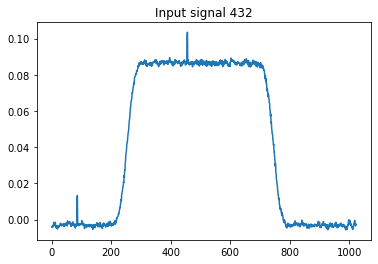

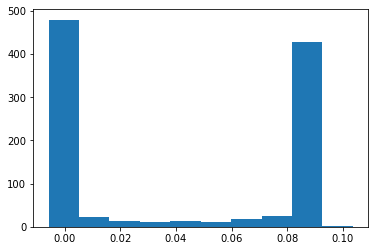

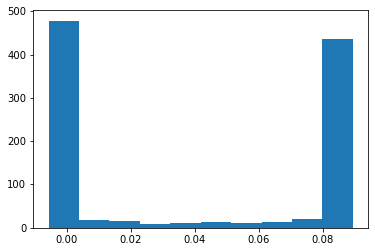

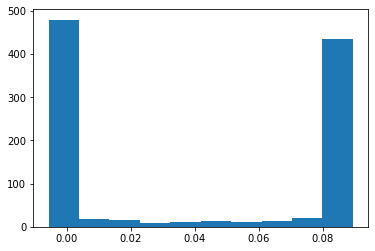

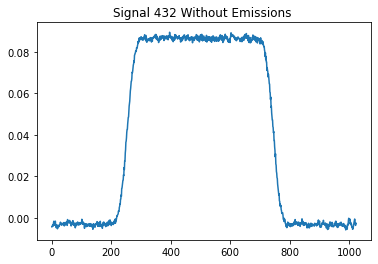

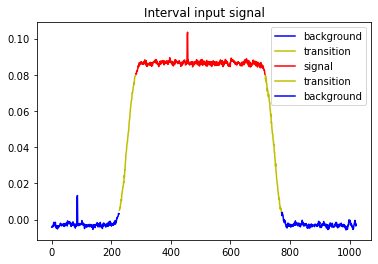

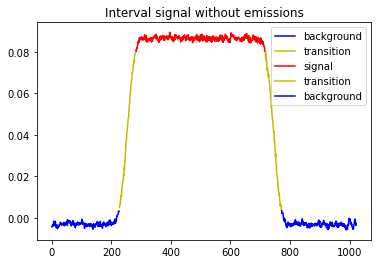

k = 4
Межгрупповая дисперсия = 2.455410668144488e-06
Внутригрупповая дисперсия = 0.007236796812612873
k = 5
Межгрупповая дисперсия = 0.0035873974032313983
Внутригрупповая дисперсия = 0.007226056614889972
k = 5
Межгрупповая дисперсия = 1.1864293169315838e-06
Внутригрупповая дисперсия = 0.007516796619624298
k = 5
Межгрупповая дисперсия = 0.0035946721017659383
Внутригрупповая дисперсия = 0.007490734587476547
k = 4
Межгрупповая дисперсия = 1.1411041808167563e-06
Внутригрупповая дисперсия = 0.005564301940615097
[0.0003392952340274361, 0.4964529887351321, 0.0001578370916454147, 0.4798824547562696, 0.00020507589145865343]
k = 32
Межгрупповая дисперсия = 0.06001496291454506
Внутригрупповая дисперсия = 0.002624254829565237
22.869335035000315


In [110]:
# считывание данных
fileData = readData("wave_ampl.txt", 1024)
# определяем номер сигнала для дальнейшего рассмотрения
idSignal = 432 # здесь меняем номер сигнала от 0 до 799, можно взять любой
# задаем массив нумерации в сигнале
indArray = createIndArray(fileData[idSignal])
# берем данные конкретного сигнала
signal = fileData[idSignal]
# изображение исходного сигнала
plotSignal(signal, indArray,"Input signal " + str(idSignal))
# деление на фон, сигнал, переходы
start, finish, types = findZones(signal)
zonesData, types = convertData(signal, indArray, start, finish, types)
# удаление выбросов
copySignal = signal.copy()
signalWithoutEmissions, zonesData, types = deleteEmissions(copySignal, indArray, zonesData, types)
plotSignal(signalWithoutEmissions, indArray,"Signal "  + str(idSignal) + " Without Emissions ")
# отрисовка областей
plotIntervals(signal, indArray, zonesData, types, "Interval input signal")
plotIntervals(signalWithoutEmissions, indArray, zonesData, types, "Interval signal without emissions")
# вычисление критерия Фишера для каждой области
fishers = calculateFisher(signal, indArray, zonesData, types)
print(fishers)
print(applayFisher(signal, 32))